In [1]:
try:
  import google.colab
  print("Running in a colab, all good")
except:
  raise "You need to run this notebook in a Google Colab !"

Running in a colab, all good


## Note before running the repo
In order to run this notebook, you need the datasets of cyclones, in a hierarchy as follows : 
```
data
  |--- ibtracs-gulf of mexico-1998-2015.csv
  |--- ibtracs-japan-1998-2015.csv
```
You can either upload the files manually to collab, or run the commands below to automatically download the files from our github repo

In [2]:
!mkdir data
!wget 'https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-gulf%20of%20mexico-1998-2015.csv' -O "data/ibtracs-gulf of mexico-1998-2015.csv"
!wget 'https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-japan-1998-2015.csv' -O "data/ibtracs-japan-1998-2015.csv"

mkdir: cannot create directory ‘data’: File exists
--2023-01-20 12:23:07--  https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-gulf%20of%20mexico-1998-2015.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235033 (230K) [text/plain]
Saving to: ‘data/ibtracs-gulf of mexico-1998-2015.csv’

data/ibtracs-gulf o 100%[===================>] 229.52K  --.-KB/s    in 0.03s   

2023-01-20 12:23:07 (8.34 MB/s) - ‘data/ibtracs-gulf of mexico-1998-2015.csv’ saved [235033/235033]

--2023-01-20 12:23:07--  https://raw.githubusercontent.com/GGomez99/ds2-2023-Project2/main/project/arens-gomez-humeau-khieu/data/ibtracs-japan-1998-2015.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.10

## Parameters and variables

In [3]:
#Notebook parameters
zoneAnalysis = "Japan"
#zoneAnalysis = "Gulf of Mexico"

In [4]:
#usefull global variables
maxLon, minLon, maxLat, minLat = 0,0,0,0
minYear = 1998
maxYear = 2015

if (zoneAnalysis == "Gulf of Mexico"):
    maxLon = 282
    minLon = 256
    maxLat = 32
    minLat = 18
else:
    maxLon = 145
    minLon = 120
    maxLat = 40
    minLat = 20

## Initialisation & Data loading

In [5]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
import numpy as np
from scipy.stats.mstats import zscore
import warnings, gc
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

Populating the interactive namespace from numpy and matplotlib


In [7]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr.

In [8]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

In [9]:
params = {"min_lat": minLat, "max_lat": maxLat, "min_lon": minLon, "max_lon": maxLon}

### SST & SSH request to bigquery database

In [67]:
%%bigquery output --project alert-ground-261008 --params $params
SELECT ROUND(lon) as lon, ROUND(lat) as lat, year, month, day, AVG(sst) AS sst, AVG(ssh) AS ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>@min_lon AND lon<@max_lon AND lat>@min_lat AND lat<@max_lat
GROUP BY ROUND(lon), ROUND(lat), year, month, day

Query is running:   0%|          |

Downloading:   0%|          |

### IBTRACS data loading

In [11]:
#data loading from zone files
cyclonesData: pd.DataFrame
if (zoneAnalysis == "Japan"):
    cyclonesData = pd.read_csv("data/ibtracs-japan-1998-2015.csv")
else:
    cyclonesData = pd.read_csv("data/ibtracs-gulf of mexico-1998-2015.csv")

#time conversion
cyclonesData.ISO_TIME = pd.to_datetime(cyclonesData.ISO_TIME)
cyclonesData["NSEC_TIME"] = cyclonesData.NSEC_TIME.astype("int64")

## Data formating & merging for final dataset

In [68]:
output = output.sort_values(['year','month','day', "lon", "lat"])
output = output.groupby(['year','month','day'])[["lon", "lat", "sst", "ssh"]].agg(lambda x: list(x)).reset_index()

In [69]:
lonLength = output["lon"].apply(lambda x : len(x))
maxLength = lonLength.max()
validIndexes = lonLength[lonLength == maxLength].index

In [71]:
#saving lon lat for inverse conversion
lonlatdata = output.iloc[validIndexes[0]]
lonlatdata = lonlatdata[["lon", "lat"]]
output = output.drop(columns=["lon", "lat"]).iloc[validIndexes]

output["ISO_TIME"] = pd.to_datetime(output[['year','month','day']])
output["NSEC_TIME"] = output.ISO_TIME.astype("int64")
output.rename(columns={"lon": "LON", "lat": "LAT"}, inplace=True)
output

,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME
1612,2002,6,2,"[27.599999999999998, 27.75, 28.349999999999998...","[0.9814750000000001, 0.9988874999999999, 1.015...",2002-06-02,1022976000000000000
1613,2002,6,3,"[27.674999999999997, 27.84375, 28.65, 28.29999...","[0.976075, 1.0042, 1.0390000000000001, 1.08925...",2002-06-03,1023062400000000000
1614,2002,6,4,"[27.525, 27.581249999999997, 28.65, 28.525, 28...","[0.982925, 1.0193, 1.0624, 1.1079500000000002,...",2002-06-04,1023148800000000000
1615,2002,6,5,"[27.787499999999998, 27.468749999999996, 28.04...","[0.99525, 1.0323125, 1.0793000000000001, 1.124...",2002-06-05,1023235200000000000
1616,2002,6,6,"[28.05, 27.6375, 27.9, 28.7, 28.56666666666666...","[1.0021, 1.0426375, 1.0975000000000001, 1.1285...",2002-06-06,1023321600000000000
...,...,...,...,...,...,...,...
6569,2015,12,28,"[25.162499999999998, 25.706249999999997, 24.59...","[0.8793, 1.1076625, 1.0347, 1.0110666666666666...",2015-12-28,1451260800000000000
6570,2015,12,29,"[24.375, 25.1625, 23.7, 25.249999999999996, 26...","[0.8756, 1.1099375, 1.0243, 1.0115333333333334...",2015-12-29,1451347200000000000
6571,2015,12,30,"[24.1875, 25.21875, 24.0, 25.325, 26.433333333...","[0.8729500000000001, 1.1075375, 1.0192, 1.0152...",2015-12-30,1451433600000000000
6572,2015,12,31,"[24.15, 25.425, 24.3, 25.374999999999996, 26.4...","[0.868, 1.097325, 1.0339, 1.01675, 1.134366666...",2015-12-31,1451520000000000000


In [38]:
coordDegreeMultiple = 0.250

cyclonesData.ISO_TIME = pd.to_datetime(cyclonesData.ISO_TIME.dt.date)
cyclonesData["CYCLONE_PRESENT"] = 1
cyclonesData.drop(columns=["LAT", "LON"])
cyclonesData.head()

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME,CYCLONE_PRESENT
0,20.086,129.000,1998187N17132,30.0,TD,899877600000000000,1998-07-08,1
1,20.254,128.858,1998187N17132,30.0,TD,899888400000000000,1998-07-08,1
2,20.450,128.700,1998187N17132,30.0,TD,899899200000000000,1998-07-08,1
3,20.632,128.575,1998187N17132,30.0,TD,899910000000000000,1998-07-08,1
4,20.800,128.450,1998187N17132,30.0,TD,899920800000000000,1998-07-08,1


In [39]:
finalData = pd.merge(left=output, right=cyclonesData[["ISO_TIME", "CYCLONE_PRESENT", "SID"]], how="left", on=['ISO_TIME'])
finalData.head()

,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME,CYCLONE_PRESENT,SID
0,2002,6,2,"[27.599999999999998, 27.75, 28.349999999999998...","[0.9814750000000001, 0.9988874999999999, 1.015...",2002-06-02,1022976000000000000,NaN,NaN
1,2002,6,3,"[27.674999999999997, 27.84375, 28.65, 28.29999...","[0.976075, 1.0042, 1.0390000000000001, 1.08925...",2002-06-03,1023062400000000000,NaN,NaN
2,2002,6,4,"[27.525, 27.581249999999997, 28.65, 28.525, 28...","[0.982925, 1.0193, 1.0624, 1.1079500000000002,...",2002-06-04,1023148800000000000,NaN,NaN
3,2002,6,5,"[27.787499999999998, 27.468749999999996, 28.04...","[0.99525, 1.0323125, 1.0793000000000001, 1.124...",2002-06-05,1023235200000000000,NaN,NaN
4,2002,6,6,"[28.05, 27.6375, 27.9, 28.7, 28.56666666666666...","[1.0021, 1.0426375, 1.0975000000000001, 1.1285...",2002-06-06,1023321600000000000,NaN,NaN


In [40]:
print("From all unique cyclones :",cyclonesData["SID"].nunique())
print(finalData["SID"].nunique(), "were matched in the sst/ssh dataset")

From all unique cyclones : 268
200 were matched in the sst/ssh dataset


# Model cyclone apparition prediction


## Hyperparameters selection

In [41]:
#free up memory
del output
gc.collect()

284

In [42]:
measures_per_day_ssh = len(finalData["ssh"].iloc[0])
measures_names_ssh = ["ssh-"+str(i) for i in range(measures_per_day_ssh)]

measures_per_day_sst = len(finalData["sst"].iloc[0])
measures_names_sst = ["sst-"+str(i) for i in range(measures_per_day_sst)]

feature_names = ["year", "month", "day", "NSEC_TIME"] + measures_names_ssh + measures_names_sst
print("Total columns : ", len(feature_names))

Total columns :  844


In [43]:
finalData["CYCLONE_PRESENT"].fillna(0, inplace=True)
if "SID" in finalData.columns: finalData.drop(columns=["SID"], inplace=True)

finalData[measures_names_ssh] = pd.DataFrame(finalData['ssh'].to_list(), columns=measures_names_ssh)
finalData[measures_names_sst] = pd.DataFrame(finalData['sst'].to_list(), columns=measures_names_sst)

finalData.head()

,year,month,day,sst,ssh,ISO_TIME,NSEC_TIME,CYCLONE_PRESENT,ssh-0,ssh-1,...,sst-410,sst-411,sst-412,sst-413,sst-414,sst-415,sst-416,sst-417,sst-418,sst-419
0,2002,6,2,"[27.599999999999998, 27.75, 28.349999999999998...","[0.9814750000000001, 0.9988874999999999, 1.015...",2002-06-02,1022976000000000000,0.0,0.981475,0.998887,...,20.53125,20.10000,20.10000,21.33750,21.61875,20.86875,18.35625,17.02500,14.88750,12.6375
1,2002,6,3,"[27.674999999999997, 27.84375, 28.65, 28.29999...","[0.976075, 1.0042, 1.0390000000000001, 1.08925...",2002-06-03,1023062400000000000,0.0,0.976075,1.004200,...,20.75625,20.41875,20.85000,21.90000,21.75000,21.31875,18.41250,17.19375,14.58750,12.6750
2,2002,6,4,"[27.525, 27.581249999999997, 28.65, 28.525, 28...","[0.982925, 1.0193, 1.0624, 1.1079500000000002,...",2002-06-04,1023148800000000000,0.0,0.982925,1.019300,...,21.30000,20.92500,21.24375,22.25625,22.38750,21.91875,19.12500,17.60625,14.96250,12.9750
3,2002,6,5,"[27.787499999999998, 27.468749999999996, 28.04...","[0.99525, 1.0323125, 1.0793000000000001, 1.124...",2002-06-05,1023235200000000000,0.0,0.995250,1.032312,...,21.63750,21.35625,21.76875,22.50000,22.72500,22.65000,19.68750,18.50625,16.10625,13.5750
4,2002,6,6,"[28.05, 27.6375, 27.9, 28.7, 28.56666666666666...","[1.0021, 1.0426375, 1.0975000000000001, 1.1285...",2002-06-06,1023321600000000000,0.0,1.002100,1.042638,...,21.75000,21.56250,21.86250,22.66875,22.66875,22.25625,19.59375,18.88125,16.76250,14.1750


In [44]:
cyclonePtCount = len(finalData[finalData.CYCLONE_PRESENT == 1])
totalDataCount = len(finalData)

print("Points labelled as cyclone present : ", cyclonePtCount, f'({cyclonePtCount/totalDataCount*100:.{2}f}%)')
print("Points labelled as cyclone not present : ",  totalDataCount-cyclonePtCount, f'({(1-cyclonePtCount/totalDataCount)*100:.{2}f}%)')

Points labelled as cyclone present :  5492 (56.76%)
Points labelled as cyclone not present :  4184 (43.24%)


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score

In [48]:
def generateData(positive_ratio, train_test_ratio):
    data = finalData[finalData["CYCLONE_PRESENT"] == 1] #getting all positive data
    data = pd.concat([
        data, 
        finalData.sample(min(int(len(data)*(1-positive_ratio)/positive_ratio), len(finalData)))
    ]) #mixing with negative data
    data.sort_values("NSEC_TIME", inplace=True)

    x = data[feature_names]
    y = data["CYCLONE_PRESENT"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=train_test_ratio, shuffle=False)

    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test, scaler

In [49]:
train_test_ratios = np.linspace(0.5, 0.9, 5)
positive_ratios = np.linspace(0.3, 0.8, 6)
precisionMatrix = []
recallMatrix = []
precisionValidMatrix = []
recallValidMatrix = []

for positive_ratio in positive_ratios:
    precisionSubMatrix = []
    recallSubMatrix = []
    precisionValidSubMatrix = []
    recallValidSubMatrix = []
    for train_test_ratio in train_test_ratios:
        print("Testing for pos/neg ratio :", positive_ratio, "; train/test :", train_test_ratio)
        #--------------data splitting
        x_train, x_test, y_train, y_test, scaler = generateData(positive_ratio, train_test_ratio)

        #-------------fitting
        model = RandomForestClassifier()

        model.fit(x_train, y_train)

        #-------------testing
        y_pred = model.predict(x_test)

        prec = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        precisionSubMatrix.append(prec)
        recallSubMatrix.append(recall)

        #--------------validation
        latest_train_date = scaler.inverse_transform(x_train[argmax(x_train[:, -1])].reshape(1,-1))[0][-1]
        validation_data = finalData[finalData["NSEC_TIME"] > latest_train_date]

        x_valid = validation_data[feature_names]
        y_valid = validation_data["CYCLONE_PRESENT"]

        y_pred_valid = model.predict(scaler.transform(x_valid))

        prec_valid = precision_score(y_valid, y_pred_valid)
        recall_valid = recall_score(y_valid, y_pred_valid)

        precisionValidSubMatrix.append(prec_valid)
        recallValidSubMatrix.append(recall_valid)


    precisionSubMatrix.reverse()
    recallSubMatrix.reverse()
    precisionMatrix.append(precisionSubMatrix)
    recallMatrix.append(recallSubMatrix)
    
    precisionValidSubMatrix.reverse()
    recallValidSubMatrix.reverse()
    precisionValidMatrix.append(precisionValidSubMatrix)
    recallValidMatrix.append(recallValidSubMatrix)

precisionMatrix.reverse()
recallMatrix.reverse()
precisionValidMatrix.reverse()
recallValidMatrix.reverse()

Testing for pos/neg ratio : 0.3 ; train/test : 0.5
Testing for pos/neg ratio : 0.3 ; train/test : 0.6
Testing for pos/neg ratio : 0.3 ; train/test : 0.7
Testing for pos/neg ratio : 0.3 ; train/test : 0.8
Testing for pos/neg ratio : 0.3 ; train/test : 0.9
Testing for pos/neg ratio : 0.4 ; train/test : 0.5
Testing for pos/neg ratio : 0.4 ; train/test : 0.6
Testing for pos/neg ratio : 0.4 ; train/test : 0.7
Testing for pos/neg ratio : 0.4 ; train/test : 0.8
Testing for pos/neg ratio : 0.4 ; train/test : 0.9
Testing for pos/neg ratio : 0.5 ; train/test : 0.5
Testing for pos/neg ratio : 0.5 ; train/test : 0.6
Testing for pos/neg ratio : 0.5 ; train/test : 0.7
Testing for pos/neg ratio : 0.5 ; train/test : 0.8
Testing for pos/neg ratio : 0.5 ; train/test : 0.9
Testing for pos/neg ratio : 0.6000000000000001 ; train/test : 0.5
Testing for pos/neg ratio : 0.6000000000000001 ; train/test : 0.6
Testing for pos/neg ratio : 0.6000000000000001 ; train/test : 0.7
Testing for pos/neg ratio : 0.6000000

In [50]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_score(ax, matrixScore, titleTxt):
    im = ax.imshow(matrixScore, cmap= 'viridis', vmin=0, vmax=1)

    ax.set_xticks([i for i in range(len(train_test_ratios))])
    ax.set_xticklabels(train_test_ratios)
    ax.set_xlabel("Train/Test ratio", size=20)

    ax.set_yticks([i for i in range(len(positive_ratios))])
    ax.set_yticklabels(np.flip(positive_ratios))
    ax.set_ylabel("Positive/Negative ratio", size=20)

    ax.set_title(titleTxt, size=20)
    return im

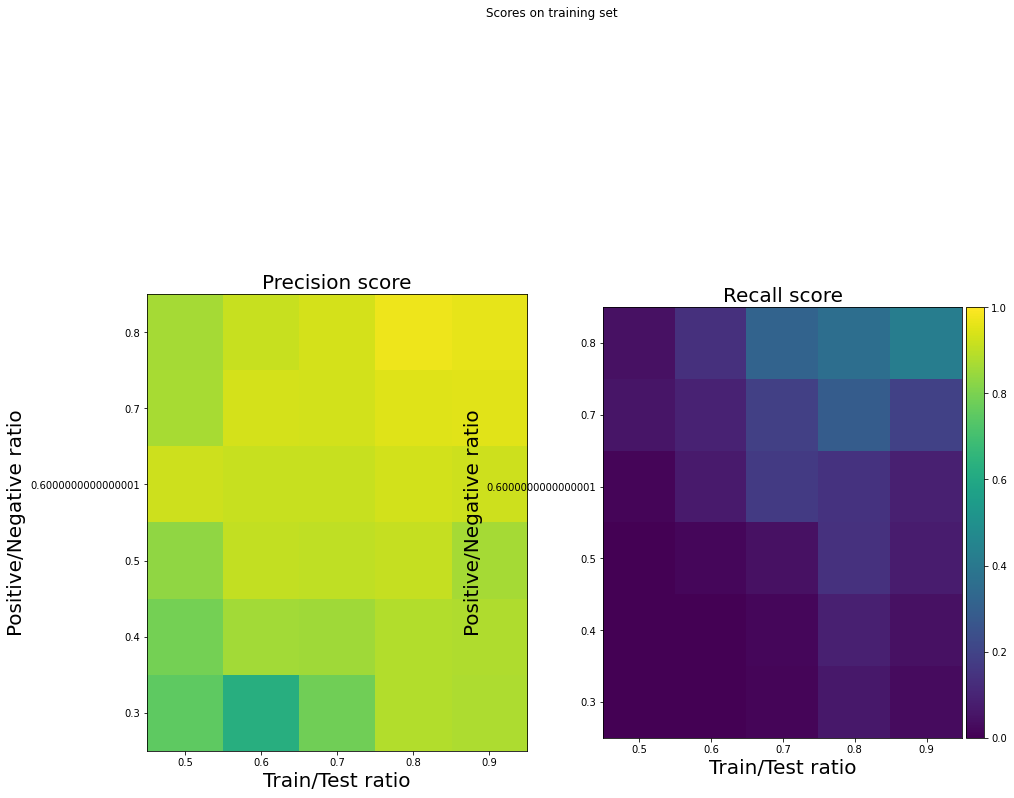

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Scores on training set')
im1 = plot_score(ax1, precisionMatrix, "Precision score")
im2 = plot_score(ax2, recallMatrix, "Recall score")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im1, cax=cax)

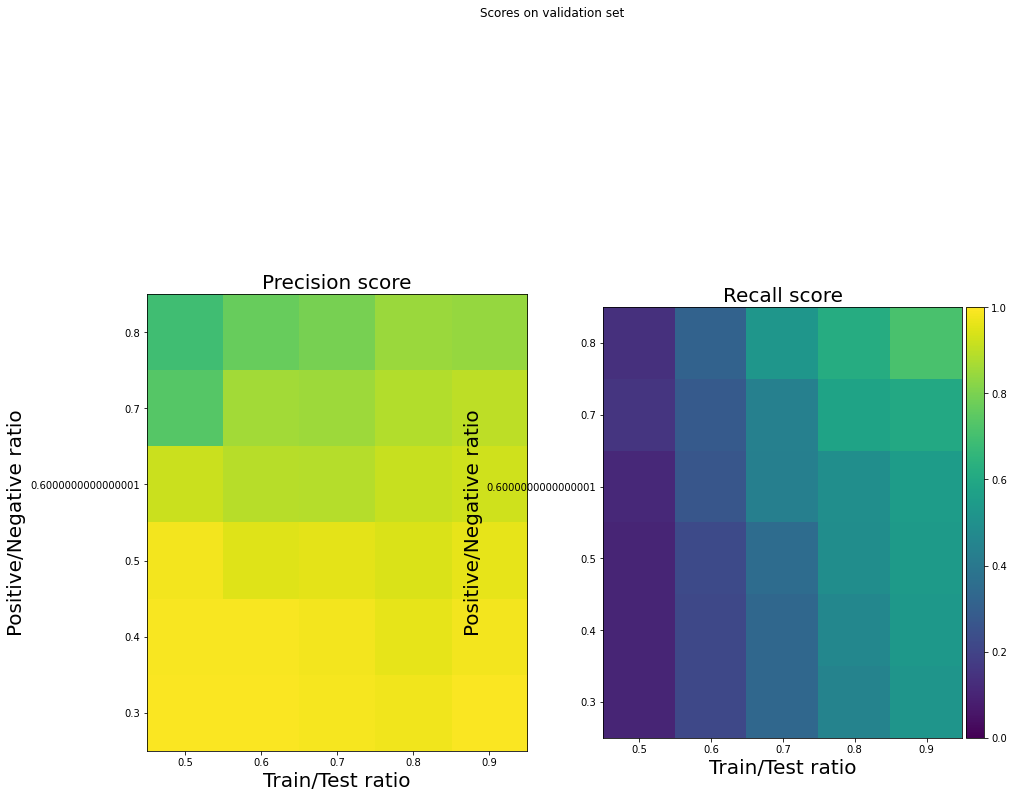

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Scores on validation set')
im1 = plot_score(ax1, precisionValidMatrix, "Precision score")
im2 = plot_score(ax2, recallValidMatrix, "Recall score")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im1, cax=cax)

In [53]:
maxForeach = [max(precisionValidMatrix[i]) for i in range(len(precisionValidMatrix))]
posRInd = maxForeach.index(max(maxForeach))
trainRInd = precisionValidMatrix[posRInd].index(max(precisionValidMatrix[posRInd]))
print("To maximize precision (",precisionValidMatrix[posRInd][trainRInd],"), best ratios are :")
print("Pos/Neg ratio :", np.flip(positive_ratios)[posRInd])
print("Train/Test ratio :", train_test_ratios[trainRInd])

To maximize precision ( 0.9947916666666666 ), best ratios are :
Pos/Neg ratio : 0.3
Train/Test ratio : 0.5


In [54]:
maxForeach = [max(recallValidMatrix[i]) for i in range(len(recallValidMatrix))]
posRInd = maxForeach.index(max(maxForeach))
trainRInd = recallValidMatrix[posRInd].index(max(recallValidMatrix[posRInd]))
print("To maximize recall (",recallValidMatrix[posRInd][trainRInd],"), best ratios are :")
print("Pos/Neg ratio :", np.flip(positive_ratios)[posRInd])
print("Train/Test ratio :", train_test_ratios[trainRInd])

To maximize recall ( 0.7135833940276766 ), best ratios are :
Pos/Neg ratio : 0.8
Train/Test ratio : 0.9


## Model validation

In [62]:
bestPosR = 0.8
bestTrainTestR = 0.9

#validating model
#--------------data splitting
x_train, x_test, y_train, y_test, scaler = generateData(bestPosR, bestTrainTestR)

#-------------fitting
model = RandomForestClassifier(n_estimators=100)

model.fit(x_train, y_train)

#-------------testing
y_pred = model.predict(x_test)

prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

#--------------validation
latest_train_date = scaler.inverse_transform(x_train[argmax(x_train[:, -1])].reshape(1,-1))[0][-1]
validation_data = finalData[finalData["NSEC_TIME"] > latest_train_date]

x_valid = validation_data[feature_names]
y_valid = validation_data["CYCLONE_PRESENT"]

y_pred_valid = model.predict(scaler.transform(x_valid))

prec_valid = precision_score(y_valid, y_pred_valid)
recall_valid = recall_score(y_valid, y_pred_valid)
roc_valid = roc_auc_score(y_valid, y_pred_valid)

print("Using pos/neg ratio =", bestPosR, "; train/test ratio =", bestTrainTestR)
print("Results for test set with", len(x_test), "points")
print("Precision :", prec)
print("Recall :", recall)
print("ROC AUC :", roc)
print("-----------------------------------------")
print("Results for validation set with", len(x_valid), "points")
print("Precision valid :", prec_valid)
print("Recall valid :", recall_valid)
print("ROC AUC valid :", roc_valid)

Using pos/neg ratio = 0.8 ; train/test ratio = 0.9
Results for test set with 6178 points
Precision : 0.9344432882414152
Recall : 0.318496187267246
ROC AUC : 0.5423649767505061
-----------------------------------------
Results for validation set with 9676 points
Precision valid : 0.6980066445182724
Recall valid : 0.3825564457392571
ROC AUC valid : 0.5826501157950588


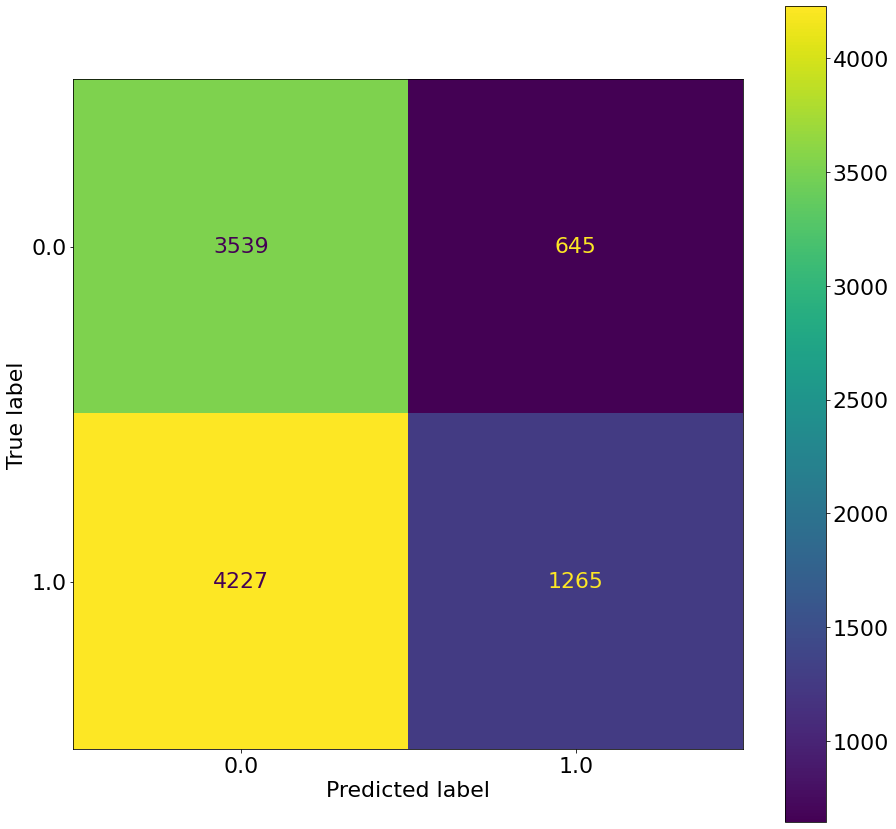

In [60]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid)

Text(0, 0.5, 'Mean decrease in impurity')

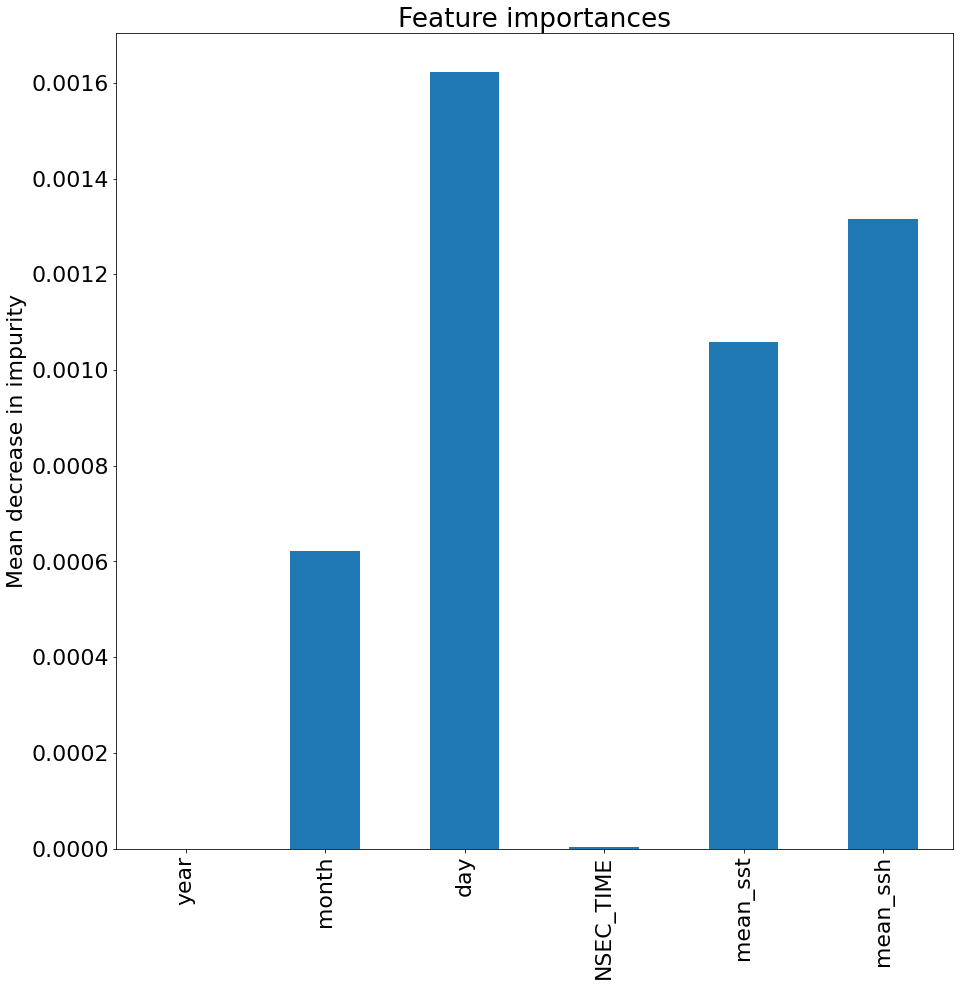

In [63]:
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

forest_importances_mean = forest_importances[["year", "month", "day", "NSEC_TIME"]]
forest_importances_mean["mean_sst"] = forest_importances[measures_names_sst].mean()
forest_importances_mean["mean_ssh"] = forest_importances[measures_names_ssh].mean()

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots()
forest_importances_mean.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")

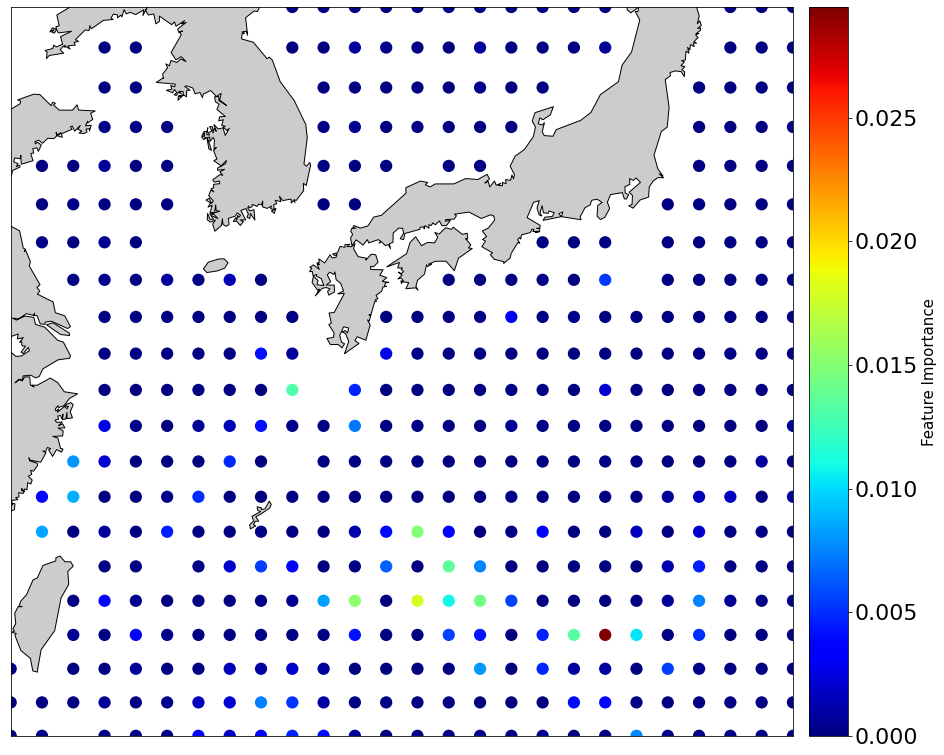

In [74]:
forest_importances_map = pd.DataFrame()

forest_importances_map["lon"] = lonlatdata["lon"]
forest_importances_map["lat"] = lonlatdata["lat"]
forest_importances_map["sst"] = forest_importances[measures_names_sst].to_numpy()
forest_importances_map["ssh"] = forest_importances[measures_names_ssh].to_numpy()

plot_im(forest_importances_map.lon, forest_importances_map.lat, forest_importances_map.sst, 150, "Feature Importance")

lon    [120.0, 120.0, 120.0, 121.0, 121.0, 121.0, 121...
lat    [20.0, 21.0, 22.0, 20.0, 21.0, 26.0, 27.0, 34....
Name: 1612, dtype: object